# Time Series Prediction

<hr/>

Predicting monthly sunspots

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

<h2>Load the data</h2>

In [3]:
dataset_path = './sunspots_data.csv'

data = pd.read_csv(dataset_path)
print("#samples:", len(data))
data.head()

#samples: 2820


,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


<h2>Visualizations</h2>

In [52]:
def plot_data(y):
    plt.figure(figsize=(18, 5))
    plt.plot([i for i in range(0, len(y))], y)
    plt.show()

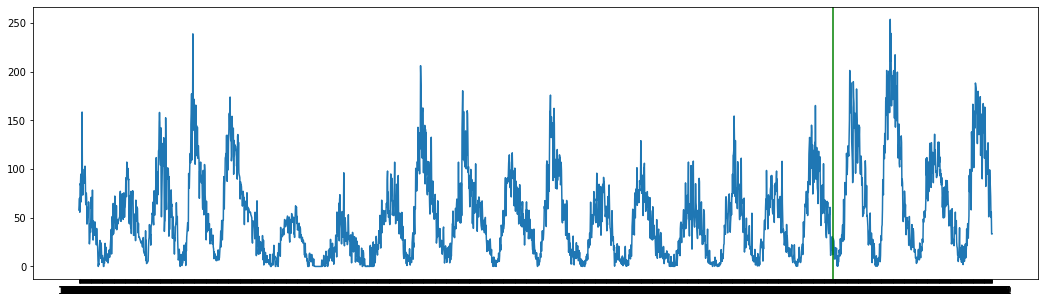

In [32]:
plt.figure(figsize=(18, 5))
plt.plot(data['Month'], data['Sunspots'])
# line separating train and validation set
plt.axvline(x='1943-01', color='g')
plt.show()

<h3>Baseline</h3>

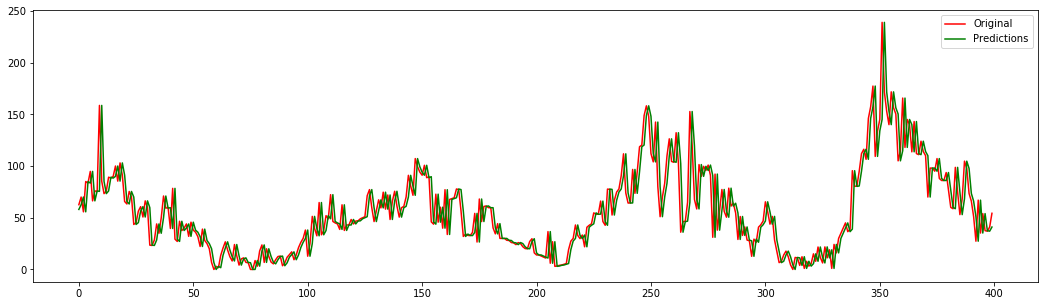

In [87]:
# creating a baseline by always predicting the previous day's value
predictions = data['Sunspots'][:-1]
t = [i for i in range(len(predictions))]
plt.figure(figsize=(18, 5))
plt.plot(t, data['Sunspots'][1:], 'r', label='Original')
plt.plot(t, predictions, 'g', label='Predictions')
plt.legend()
plt.show()

In [88]:
loss = 0
for target, pred in zip(data['Sunspots'][1:], predictions):
    loss += pow(target - pred, 2)

mse = loss / len(predictions)
rmse = pow(mse, 0.5)

print('MSE:', mse)
print('RMSE:', rmse)

MSE: 414.137725
RMSE: 20.35037407518594


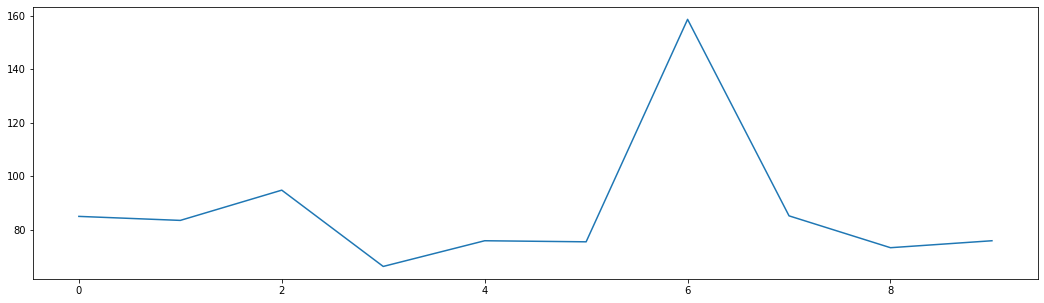

In [54]:
plot_data(X_train[4])

<h3>Create dataset with windowing</h3>

In [92]:
window = 3
seq_len = 10
X, y = [], []

assert window <= seq_len

for i in range(0, len(data)-seq_len, window):
    spots_seq = []
    for spots in data.iloc[i:i+seq_len+1]['Sunspots']:
        spots_seq.append(spots)
    X.append(spots_seq[:-1])
    y.append(spots_seq[-1])
    
print('Dataset generated')
print('#Samples:', len(X))

# print(X, y)

Dataset generated
#Samples: 937


In [51]:
# split into train and validation sets
split_pt = data.loc[data['Month'] == '1943-01'].index[0]
X_train, X_val, y_train, y_val = X[:split_pt], X[split_pt:], y[:split_pt], y[split_pt:]

print('#Training samples:', len(X_train))
print('#Validation samples:', len(X_val))
print('Fraction of validation samples wrt total:', round(len(X_val) / len(X_train), 2))

#Training samples: 2328
#Validation samples: 482
Fraction of validation samples wrt total: 0.21


<h2>Model</h2>

In [33]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [76]:
# define the model, loss and optimizer, and print the summary
model = tf.keras.Sequential([
    tf.keras.layers.Input((seq_len, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(seq_len+1,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(seq_len+1)),
    tf.keras.layers.Dense(30, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['mae'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_10 (Bidirectio (None, 10, 40)            3520      
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 40)                9760      
_________________________________________________________________
dense_10 (Dense)             (None, 40)                1640      
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 41        
Total params: 14,961
Trainable params: 14,961
Non-trainable params: 0
_________________________________________________________________


In [52]:
X_train, X_val = np.array(X_train), np.array(X_val)
y_train, y_val = np.array(y_train), np.array(y_val)

X_train = X_train.reshape(-1, seq_len, 1)
X_val = X_val.reshape(-1, seq_len, 1)

In [77]:
history = model.fit(X_train, y_train, epochs=80, validation_data=(X_val, y_val), batch_size=24)

Epoch 1/80
97/97 [==============================] - 1s 15ms/step - loss: 2883.4849 - mae: 39.6897 - val_loss: 7733.5698 - val_mae: 68.1149
Epoch 2/80
97/97 [==============================] - 1s 6ms/step - loss: 2366.9094 - mae: 35.0197 - val_loss: 7168.8384 - val_mae: 64.6928
Epoch 3/80
97/97 [==============================] - 1s 6ms/step - loss: 2104.9001 - mae: 31.8125 - val_loss: 6691.7246 - val_mae: 61.6823
Epoch 4/80
97/97 [==============================] - 1s 6ms/step - loss: 1900.4579 - mae: 29.6170 - val_loss: 6272.4702 - val_mae: 59.0910
Epoch 5/80
97/97 [==============================] - 1s 6ms/step - loss: 1715.1084 - mae: 27.6256 - val_loss: 5896.2612 - val_mae: 56.7931
Epoch 6/80
97/97 [==============================] - 1s 6ms/step - loss: 1563.6255 - mae: 26.0518 - val_loss: 5558.8311 - val_mae: 54.7242
Epoch 7/80
97/97 [==============================] - 1s 6ms/step - loss: 1432.0178 - mae: 24.5233 - val_loss: 5248.2017 - val_mae: 52.8293
Epoch 8/80
97/97 [===============

97/97 [==============================] - 1s 7ms/step - loss: 267.0294 - mae: 11.4045 - val_loss: 887.7776 - val_mae: 19.7479
Epoch 61/80
97/97 [==============================] - 1s 6ms/step - loss: 262.9008 - mae: 11.2204 - val_loss: 876.2250 - val_mae: 19.6507
Epoch 62/80
97/97 [==============================] - 1s 5ms/step - loss: 258.8722 - mae: 11.2105 - val_loss: 854.0889 - val_mae: 19.5358
Epoch 63/80
97/97 [==============================] - 1s 5ms/step - loss: 255.0005 - mae: 11.1329 - val_loss: 840.0133 - val_mae: 19.4632
Epoch 64/80
97/97 [==============================] - 1s 6ms/step - loss: 255.1124 - mae: 11.2250 - val_loss: 829.9435 - val_mae: 19.1476
Epoch 65/80
97/97 [==============================] - 1s 6ms/step - loss: 256.7935 - mae: 11.0802 - val_loss: 820.2950 - val_mae: 19.2059
Epoch 66/80
97/97 [==============================] - 1s 7ms/step - loss: 256.5358 - mae: 11.1186 - val_loss: 800.5003 - val_mae: 19.0394
Epoch 67/80
97/97 [==============================] - 

In [62]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

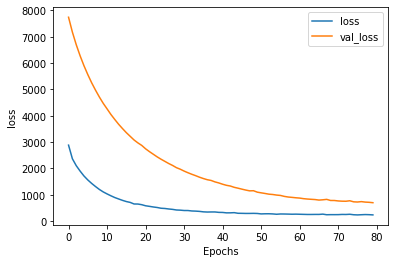

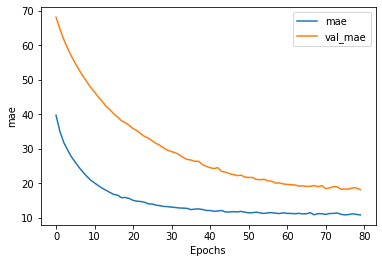

In [78]:
plot_graphs(history, 'loss')
plot_graphs(history, 'mae')